In [1]:
import utils
import plotting
import postprocessing
import corrections

from utils import CUT_MAX_VAL
from hh_vars import years, sig_key, data_key, qcd_key, bg_keys, samples, txbb_wps
from postprocessing import (
    shape_var,
    shape_bins,
    blind_window,
    selection_regions,
    selection_regions_label,
    # selection_regions_year,
    filters,
)

import numpy as np
import pandas as pd
from pandas.errors import SettingWithCopyWarning
from hist import Hist

import os
from copy import deepcopy
from inspect import cleandoc
import warnings

import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 16})

# ignore these because they don't seem to apply
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
MAIN_DIR = "../../../"
samples_dir = f"{MAIN_DIR}/../data/skimmer/Jan31"
signal_samples_dir = f"{MAIN_DIR}/../data/skimmer/Feb3"
year = "2017"

plot_dir = "../../../plots/PostProcessing/Feb17"
templates_dir = "templates/Jan31/"
_ = os.system(f"mkdir -p {plot_dir}")
_ = os.system(f"mkdir -p {templates_dir}")

In [ ]:
systematics = {}

Load samples

In [ ]:
cutflow = pd.DataFrame(index=list(samples.keys()))
events_dict = utils.load_samples(signal_samples_dir, {sig_key: samples[sig_key]}, year, filters)
events_dict |= utils.load_samples(
    samples_dir, {k: samples[k] for k in samples.keys() - [sig_key]}, year, filters
)
utils.add_to_cutflow(events_dict, "BDTPreselection", "weight", cutflow)

# print weighted sample yields
for sample in events_dict:
    tot_weight = np.sum(events_dict[sample]["weight"].values)
    print(f"Pre-selection {sample} yield: {tot_weight:.2f}")

Scale factors, bb VV assignment, derive variables

In [ ]:
postprocessing.apply_weights(events_dict, year, cutflow)
bb_masks = postprocessing.bb_VV_assignment(events_dict)
postprocessing.derive_variables(events_dict, bb_masks)

Lund plane SFs

In [ ]:
events = events_dict[sig_key]
events = postprocessing.postprocess_lpsfs(events)
events["finalWeight_preLP"] = events["finalWeight"]
events["finalWeight"] = events["finalWeight"] * events["VV_lp_sf_nom"][0]
events_dict[sig_key] = events

In [ ]:
postprocessing.load_bdt_preds(events_dict, f"{samples_dir}/{year}/preds.npy", list(samples.keys()))

Overall BDT SF

In [ ]:
sel, cf = utils.make_selection(
    selection_regions[year]["BDTOnly"], events_dict, bb_masks, prev_cutflow=cutflow
)
lp_sf, unc, uncs = postprocessing.get_lpsf(events_dict[sig_key], sel[sig_key])
systematics["lp_sf_unc"] = unc / lp_sf

Templates

Pass Region

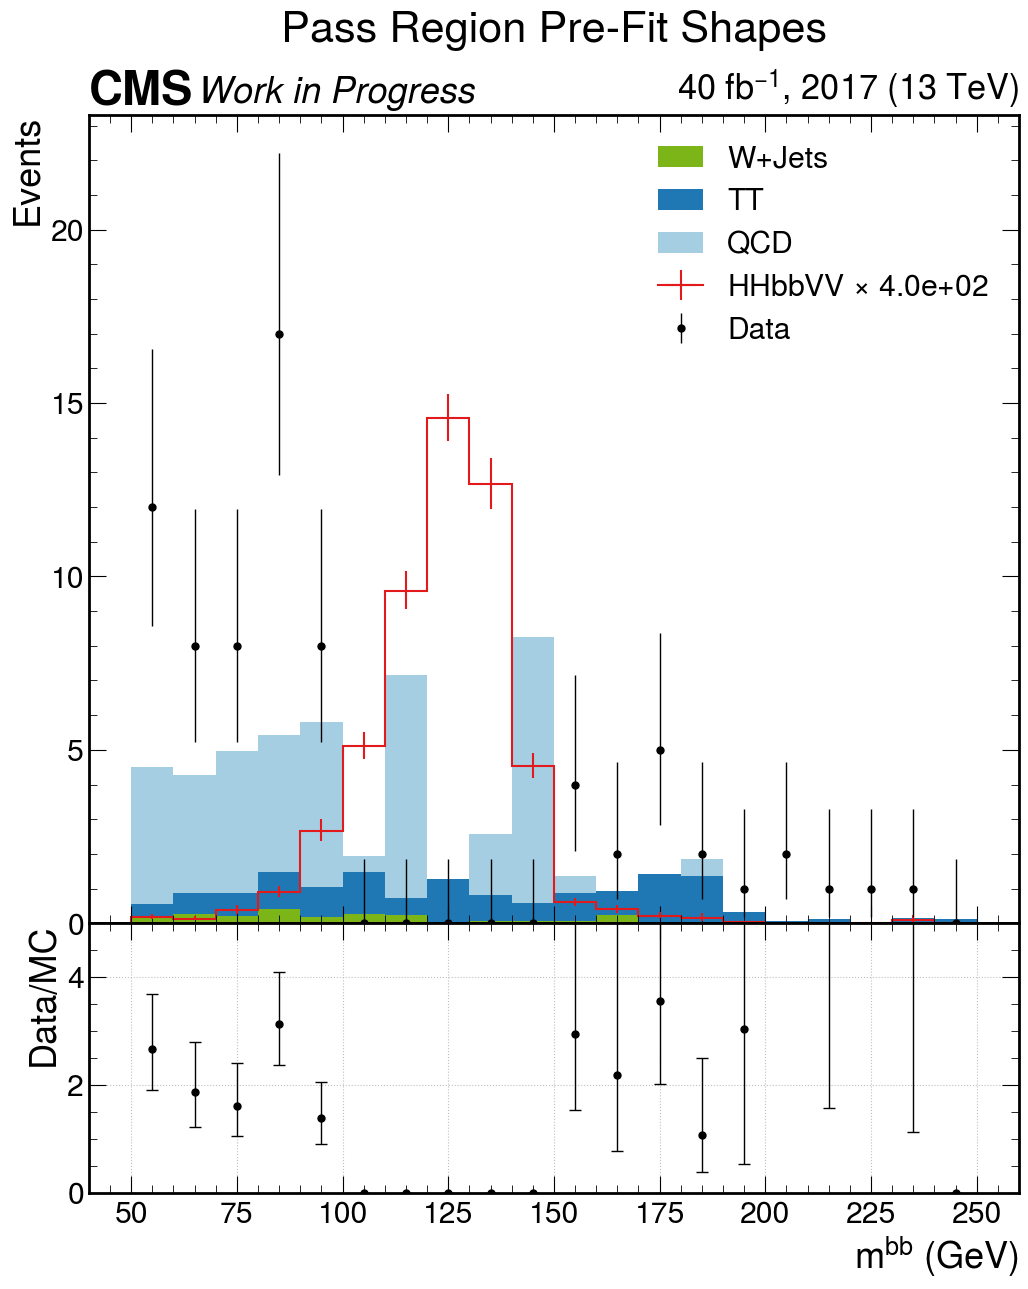

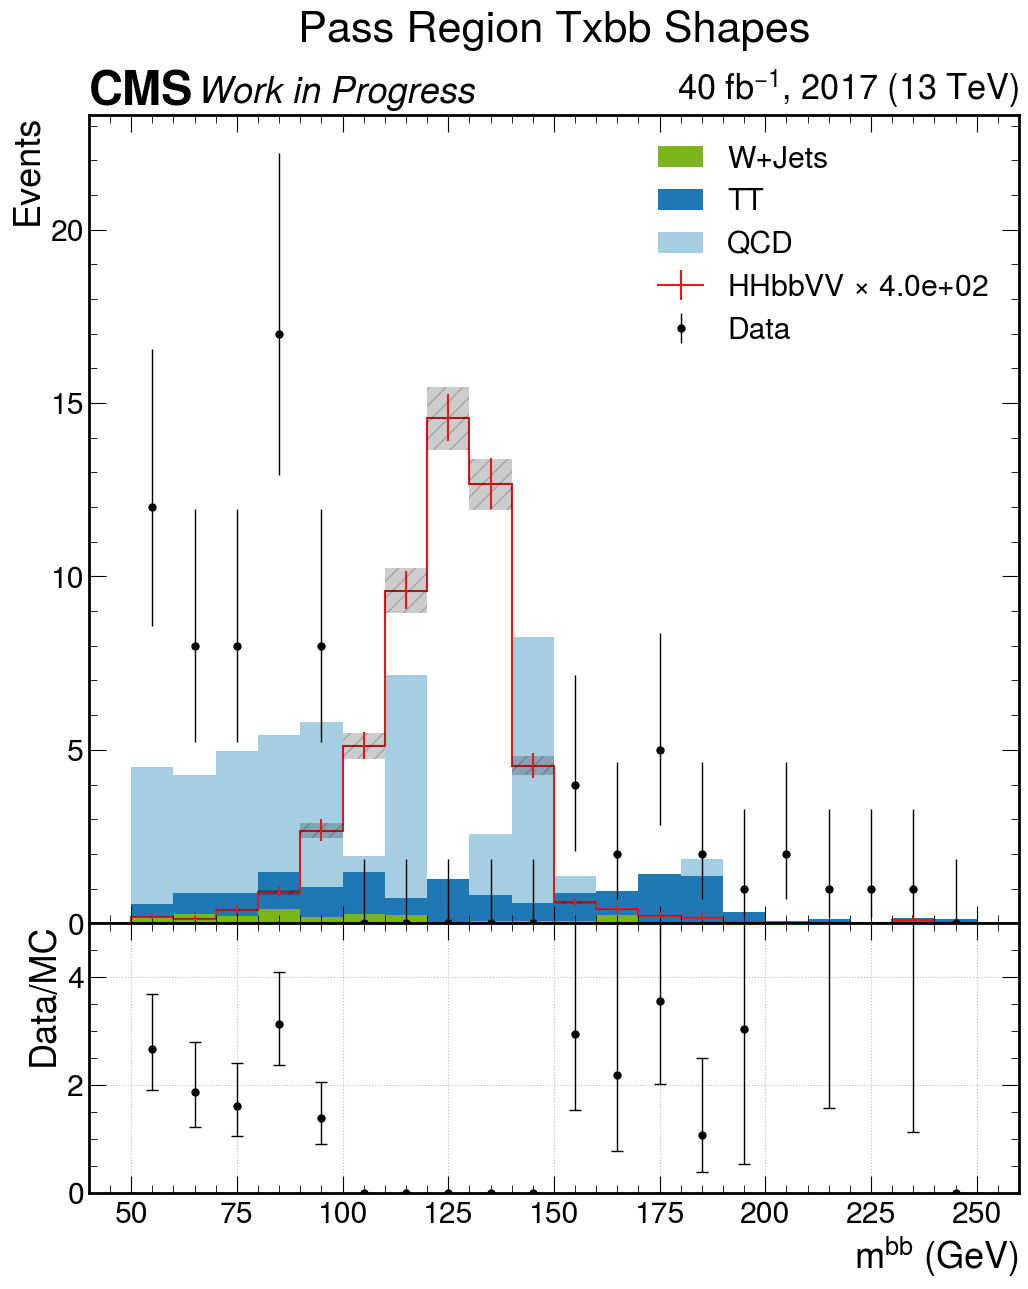

In [53]:
prev_cutflow = cutflow
weight_key = "finalWeight"
cutstr = ""
show = True

for label, region in selection_regions[year].items():
    # print(region)
    pass_region = label.startswith("pass")

    if not pass_region:
        continue

    sel, cf = utils.make_selection(region, events_dict, bb_masks, prev_cutflow=prev_cutflow)

    # ParticleNetMD Txbb SFs
    sig_events = deepcopy(events_dict[sig_key][sel[sig_key]])
    sig_bb_mask = bb_masks[sig_key][sel[sig_key]]
    if pass_region:
        corrections.apply_txbb_sfs(sig_events, sig_bb_mask, year, weight_key)

    # set up samples
    hist_samples = list(events_dict.keys())
    for var in ["down", "up"]:
        if pass_region:
            hist_samples.append(f"{sig_key}_txbb_{var}")

    var = shape_var[0]

    h = (
        Hist.new.StrCat(hist_samples, name="Sample")
        .Reg(*shape_bins, name=var, label=shape_var[1])
        .Weight()
    )

    for sample in events_dict:
        if sample == sig_key:
            events = sig_events
        else:
            events = events_dict[sample][sel[sample]]

        bb_mask = bb_masks[sample][sel[sample]]
        fill_data = {var: utils.get_feat(events, var, bb_mask)}
        weight = events[weight_key].values.squeeze()
        h.fill(Sample=sample, **fill_data, weight=weight)

    if pass_region:
        # blind Higgs mass window in pass region in data
        utils.blindBins(h, blind_window, data_key)

    if pass_region:
        # ParticleNetMD Txbb SFs
        fill_data = {shape_var[0]: utils.get_feat(sig_events, shape_var[0], sig_bb_mask)}
        for var in ["down", "up"]:
            h.fill(
                Sample=f"{sig_key}_txbb_{var}",
                **fill_data,
                weight=sig_events[f"{weight_key}_txbb_{var}"],
            )

    sig_scale = utils.getSignalPlotScaleFactor(events_dict, selection=sel)

    if plot_dir != "":
        plotting.ratioHistPlot(
            h,
            bg_keys,
            sig_err=None,
            title=f"{selection_regions_label[label]} Region Pre-Fit Shapes",
            name=f"{plot_dir}/{cutstr}{label}_region_bb_mass.pdf",
            sig_scale=sig_scale / 2,
            show=show,
        )

        plotting.ratioHistPlot(
            h,
            bg_keys,
            sig_err="txbb",
            title=f"{selection_regions_label[label]} Region Txbb Shapes",
            name=f"{plot_dir}/{cutstr}{label}_region_bb_mass_txbb.pdf",
            sig_scale=sig_scale / 2,
            show=show,
        )